### Author: Sophie Choe

#### Portland State University, Electrical and Computer Engineering

February 2022

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

# 6-qumode Classifier

Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the image data
X_train, X_test = X_train / 255.0, X_test / 255.0

With 6 qumodes and the 'probability' measurement method, the size of the output vectors will be cutoff dimension^6. Setting cutoff dimension = 2, we extract vectors of size 2^6 and view them as one-hot encoded labels. Hence we convert the original labels to vectors of size 2^6 by padding with zeros.

In [3]:
def one_hot(labels):  
       
    depth = 2**6       # 2^6 = 64: 10 classes + 54 zeros for padding
        
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

In [4]:
keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(72, activation ="elu"),
                                 layers.Dense(46, activation ="elu"),
                                ])

# More than a million parameters for the classical circuit
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 72)                9288      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                3358      
Total params: 113,126
Trainable params: 113,126
Non-trainable params: 0
_________________________________________________________________


## 2. Quantum Data Encoding

quantum state preparation by using the output of the classical network as parameters

In [5]:
def encode_data(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Squeezing(x[4], x[5], wires=2)
    qml.Squeezing(x[6], x[7], wires=3)
    qml.Squeezing(x[8], x[9], wires=4)  
    qml.Squeezing(x[10], x[11], wires=5) 
    
    qml.Beamsplitter(x[12], x[13], wires=[0,1])
    qml.Beamsplitter(x[14], x[15], wires=[1,2])
    qml.Beamsplitter(x[16], x[17], wires=[2,3])
    qml.Beamsplitter(x[18], x[19], wires=[3,4])    
    qml.Beamsplitter(x[20], x[21], wires=[4,5]) 
    
    qml.Rotation(x[22], wires=0)
    qml.Rotation(x[23], wires=1)
    qml.Rotation(x[24], wires=2)
    qml.Rotation(x[25], wires=3)
    qml.Rotation(x[26], wires=4)
    qml.Rotation(x[27], wires=5)
   
    qml.Displacement(x[28], x[29], wires=0)   
    qml.Displacement(x[30], x[31], wires=1)
    qml.Displacement(x[32], x[33], wires=2)
    qml.Displacement(x[34], x[35], wires=3)
    qml.Displacement(x[36], x[37], wires=4)
    qml.Displacement(x[38], x[39], wires=5)    
 
    qml.Kerr(x[40], wires=0)
    qml.Kerr(x[41], wires=1)
    qml.Kerr(x[42], wires=2)
    qml.Kerr(x[43], wires=3)
    qml.Kerr(x[44], wires=4)
    qml.Kerr(x[45], wires=5)    

## 3. Quantum neural network

In [6]:
def layer(v):
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])
    qml.Beamsplitter(v[4], v[5], wires=[2,3])
    qml.Beamsplitter(v[6], v[7], wires=[3,4])    
    qml.Beamsplitter(v[8], v[9], wires=[4,5])    

    qml.Rotation(v[10], wires=0)
    qml.Rotation(v[11], wires=1)
    qml.Rotation(v[12], wires=2)
    qml.Rotation(v[13], wires=3)
    qml.Rotation(v[14], wires=4)
    qml.Rotation(v[15], wires=5)
    
    # Squeezers
    qml.Squeezing(v[16], 0.0, wires=0)
    qml.Squeezing(v[17], 0.0, wires=1)
    qml.Squeezing(v[18], 0.0, wires=2)
    qml.Squeezing(v[19], 0.0, wires=3)
    qml.Squeezing(v[20], 0.0, wires=4)
    qml.Squeezing(v[21], 0.0, wires=5)
    
    # Interferometer 2
    qml.Beamsplitter(v[22], v[23], wires=[0,1])    
    qml.Beamsplitter(v[24], v[25], wires=[1,2])
    qml.Beamsplitter(v[26], v[27], wires=[2,3])
    qml.Beamsplitter(v[28], v[29], wires=[3,4])
    qml.Beamsplitter(v[30], v[31], wires=[4,5])

    qml.Rotation(v[32], wires=0)
    qml.Rotation(v[33], wires=1)
    qml.Rotation(v[34], wires=2)
    qml.Rotation(v[35], wires=3)
    qml.Rotation(v[36], wires=4)    
    qml.Rotation(v[37], wires=5)    

    # Bias addition
    qml.Displacement(v[38], 0.0, wires=0)
    qml.Displacement(v[39], 0.0, wires=1)
    qml.Displacement(v[40], 0.0, wires=2)
    qml.Displacement(v[41], 0.0, wires=3)
    qml.Displacement(v[42], 0.0, wires=4)
    qml.Displacement(v[43], 0.0, wires=5)    

    # Non-linear activation function
    qml.Kerr(v[44], wires=0)
    qml.Kerr(v[45], wires=1)
    qml.Kerr(v[46], wires=2)
    qml.Kerr(v[47], wires=3)
    qml.Kerr(v[48], wires=4)
    qml.Kerr(v[49], wires=5)    
    

## 4. Parameter initialization

Initialize parameters for the quantum layers: number of layers x number of parameters needed for all the gates

In [7]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 10+6  # Number of interferometer parameters: 5 2-parameter beamsplitters + 6 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

## 5. Quantum device

In [8]:
num_modes = 6
cutoff_dim = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    encode_data(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)

    return qml.probs(wires=[0, 1, 2, 3, 4, 5])

## 6. Quantum device

In [9]:
num_layers = 4

# initialize weights for quantum layers
weights = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weights.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim = 4)

# add to the classical sequential model
model.add(qlayer)

## 7. Loss function and optimizer

In [10]:
opt = keras.optimizers.SGD(lr = 0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

## 8. Training

In [11]:
hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 100,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (X_test, y_test))

Epoch 1/100
10/10 [==============================] - 8357s 859s/step - loss: 3.7070 - accuracy: 0.1383 - val_loss: 2.2152 - val_accuracy: 0.3700
Epoch 2/100
10/10 [==============================] - 6072s 604s/step - loss: 2.2122 - accuracy: 0.3447 - val_loss: 1.9604 - val_accuracy: 0.4800
Epoch 3/100
10/10 [==============================] - 12431s 1316s/step - loss: 1.9008 - accuracy: 0.4466 - val_loss: 1.9859 - val_accuracy: 0.4600
Epoch 4/100
10/10 [==============================] - 11804s 1149s/step - loss: 1.7283 - accuracy: 0.5281 - val_loss: 1.8944 - val_accuracy: 0.5100
Epoch 5/100
10/10 [==============================] - 5996s 591s/step - loss: 1.6630 - accuracy: 0.5632 - val_loss: 1.7507 - val_accuracy: 0.5000
Epoch 6/100
10/10 [==============================] - 5508s 544s/step - loss: 1.4991 - accuracy: 0.5966 - val_loss: 1.6667 - val_accuracy: 0.5400
Epoch 7/100
10/10 [==============================] - 5357s 532s/step - loss: 1.4138 - accuracy: 0.6409 - val_loss: 1.6754 - va

Epoch 57/100
10/10 [==============================] - 11317s 1190s/step - loss: 0.4525 - accuracy: 0.9189 - val_loss: 1.2150 - val_accuracy: 0.6800
Epoch 58/100
10/10 [==============================] - 13054s 1233s/step - loss: 0.3945 - accuracy: 0.9293 - val_loss: 1.1198 - val_accuracy: 0.6800
Epoch 59/100
10/10 [==============================] - 36450s 3973s/step - loss: 0.3795 - accuracy: 0.9445 - val_loss: 1.0592 - val_accuracy: 0.7100
Epoch 60/100
10/10 [==============================] - 11047s 1158s/step - loss: 0.3818 - accuracy: 0.9422 - val_loss: 1.1002 - val_accuracy: 0.6700
Epoch 61/100
10/10 [==============================] - 5842s 575s/step - loss: 0.3631 - accuracy: 0.9496 - val_loss: 1.1496 - val_accuracy: 0.6700
Epoch 62/100
10/10 [==============================] - 5901s 590s/step - loss: 0.3542 - accuracy: 0.9565 - val_loss: 1.2038 - val_accuracy: 0.7000
Epoch 63/100
10/10 [==============================] - 5873s 584s/step - loss: 0.3886 - accuracy: 0.9418 - val_loss: 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 72)                9288      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                3358      
_________________________________________________________________
keras_layer (KerasLayer)     (None, 4)                 200       
Total params: 113,326
Trainable params: 113,326
Non-trainable params: 0
_________________________________________________________________


## 9. Loss and accuracy graphs

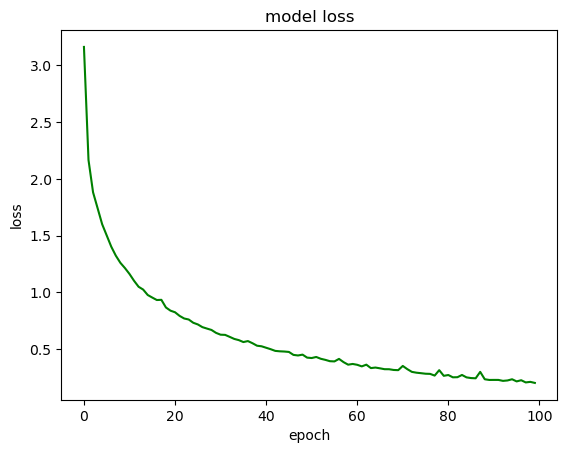

In [13]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

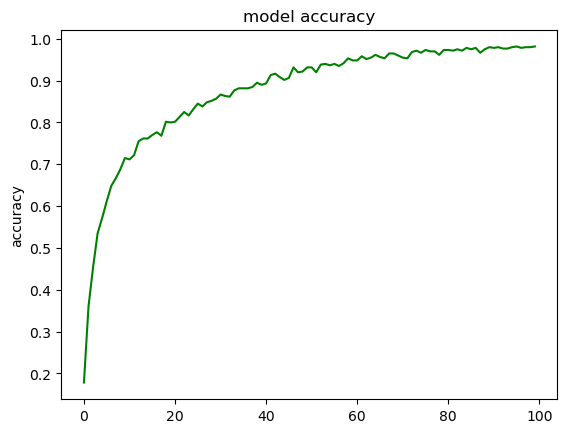

In [14]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()